In [1]:
import gluonts
import mxnet

print(gluonts.__version__)
print(mxnet.__version__)

0.4.1
1.4.1


In [2]:
# standard imports
import numpy as np
import pandas as pd

# Vis
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

# mxnet
import mxnet as mx

# gluonts
from gluonts.dataset.util import to_pandas

# imports from utility function
import utils_gluonts10 as utils
from utils_gluonts10 import get_dataset, dataset_recipes

In [3]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['m4_daily', 'm4_daily_domain', 'm4_daily_id', 'm4_hourly', 'm4_hourly_id', 'm4_monthly', 'm4_monthly_atm', 'm4_monthly_dates', 'm4_monthly_demographic', 'm4_monthly_domain', 'm4_monthly_finance', 'm4_monthly_id', 'm4_monthly_industry', 'm4_monthly_macro', 'm4_monthly_micro', 'm4_monthly_micro_atm', 'm4_monthly_nonmicro_10975_seed42', 'm4_monthly_nonmicro_10975_seed43', 'm4_monthly_nonmicro_10975_seed44', 'm4_monthly_nonmicro_10975_seed45', 'm4_monthly_nonmicro_10975_seed46', 'm4_monthly_nonmicro_10975_seed47', 'm4_monthly_nonmicro_10975_seed48', 'm4_monthly_nonmicro_10975_seed49', 'm4_monthly_nonmicro_10975_seed50', 'm4_monthly_nonmicro_10975_seed51', 'm4_monthly_other', 'm4_quarterly', 'm4_quarterly_atm', 'm4_quarterly_dates', 'm4_quarterly_demographic', 'm4_quarterly_domain', 'm4_quarterly_finance', 'm4_quarterly_id', 'm4_quarterly_industry', 'm4_quarterly_macro', 'm4_quarterly_micro', 'm4_quarterly_other', 'm4_weekly', 'm4_weekly_domain', 'm4_weekly_id', 'my_wee

In [5]:
dataname = "m4_hourly_id"
dataset = get_dataset(dataname, regenerate=False)

INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_hourly_id.


In [6]:
# get the first time series in the training set
train_entry = next(iter(dataset.train))
test_entry = next(iter(dataset.test))

# check keys
print(train_entry.keys())
print(test_entry.keys())

dict_keys(['start', 'item_id', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'item_id', 'target', 'feat_static_cat', 'source'])


In [7]:
train_entry

{'start': Timestamp('1750-01-01 00:00:00', freq='H'),
 'item_id': 'H1',
 'target': array([605., 586., 586., 559., 511., 443., 422., 395., 382., 370., 383.,
        397., 420., 455., 493., 554., 610., 666., 715., 755., 778., 794.,
        806., 808., 776., 723., 709., 660., 585., 527., 462., 437., 413.,
        407., 404., 420., 441., 471., 526., 571., 612., 635., 613., 608.,
        614., 637., 669., 683., 687., 660., 661., 632., 573., 521., 481.,
        452., 447., 425., 427., 441., 438., 472., 528., 596., 661., 708.,
        754., 781., 808., 819., 820., 801., 770., 717., 697., 655., 607.,
        552., 512., 475., 452., 436., 429., 433., 430., 472., 536., 611.,
        662., 705., 707., 718., 733., 741., 737., 710., 647., 593., 564.,
        528., 507., 466., 428., 396., 382., 371., 374., 372., 373., 406.,
        451., 480., 487., 487., 494., 505., 519., 535., 560., 570., 551.,
        541., 552., 521., 477., 426., 395., 370., 357., 349., 362., 374.,
        402., 427., 456., 500.

In [8]:
dataset.metadata.feat_static_cat

[<CategoricalFeatureInfo name='feat_static_cat' cardinality='414'>]

In [9]:
[feat_static_cat.cardinality for feat_static_cat in dataset.metadata.feat_static_cat]

['414']

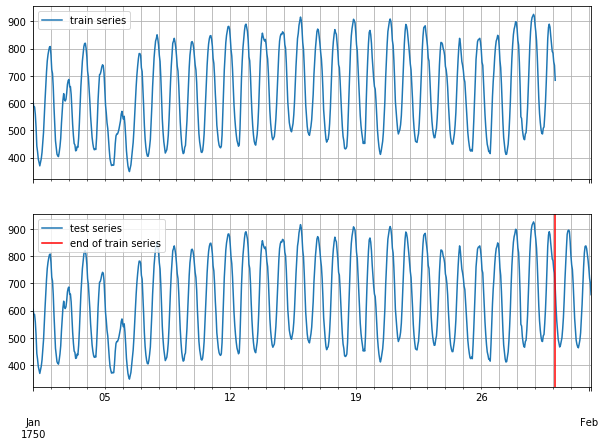

In [10]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [11]:
# gluonts
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

# DeepAREstimator
from gluonts.model.deepar import DeepAREstimator

INFO:root:Using CPU


In [ ]:
print(dataname)
epochs=500
num_batches = 100

mx.random.seed(44)
np.random.seed(44)

trainer = Trainer(
    ctx=mx.cpu(0),
    epochs=epochs,
    num_batches_per_epoch=num_batches,
    learning_rate=1e-3,
)

estimator = DeepAREstimator(
    trainer=trainer,
    cardinality= [
        feat_static_cat.cardinality 
        for feat_static_cat in dataset.metadata.feat_static_cat
    ],
#     context_length=dataset.metadata.prediction_length,
    prediction_length=dataset.metadata.prediction_length,
    freq=dataset.metadata.freq,
    use_feat_static_cat=True
)

predictor = estimator.train(training_data=dataset.train)

forecast_it, ts_it = make_evaluation_predictions(
    dataset.test, predictor=predictor, num_samples=100
    )

agg_metrics, item_metrics = Evaluator()(
    ts_it, forecast_it, num_series=len(dataset.test)
)

m4_hourly_id


INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:22<00:00,  4.37it/s, avg_epoch_loss=4.88]
INFO:root:Epoch[0] Elapsed time 22.894 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=4.878127
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:24<00:00,  4.10it/s, avg_epoch_loss=4.19]
INFO:root:Epoch[1] Elapsed time 24.373 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=4.186225
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:27<00:00,  3.69it/s, avg_epoch_loss=3.73]
INFO:root:Epoch[2] Elapsed time 27.142 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=3.733975
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:22<00:00,  4.35it/s, avg_epoch_loss=3.87]
INFO:root:Epoch[3] Elapsed time 22.976 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=3.867704
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:28<00:00,  3.49it/s, a

100%|██████████| 100/100 [00:19<00:00,  5.02it/s, avg_epoch_loss=3.14]
INFO:root:Epoch[36] Elapsed time 19.936 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=3.137239
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:19<00:00,  5.01it/s, avg_epoch_loss=2.98]
INFO:root:Epoch[37] Elapsed time 19.967 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=2.984734
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:20<00:00,  4.92it/s, avg_epoch_loss=2.81]
INFO:root:Epoch[38] Elapsed time 20.338 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=2.809830
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:21<00:00,  4.59it/s, avg_epoch_loss=3.05]
INFO:root:Epoch[39] Elapsed time 21.792 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=3.048479
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:20<00:00,  4.99it/s, avg_epoch_loss=3.14]
INFO:root:Epoch[40] Elapsed time 20.041 s

In [ ]:
metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}

pd.DataFrame([output])

In [ ]:
item_metrics.head()

In [25]:
item_metrics.to_csv("m4_hourly_id_deepar_metrics_owa0000.csv")